In [164]:
import networkx as nx
import pandas as pd
import numpy as np
import math
import os

from sklearn.cluster import KMeans
from multiprocessing import Pool

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from stats import remove_isolates

In [165]:
# save plots
folder = "geocluster_plots"

# Create the folder if it doesn't exist
os.makedirs(folder, exist_ok=True)

In [166]:
G = nx.read_gexf('mto_author_interactions_collapsed_geo.gexf')
G = remove_isolates(G)

df_authors_og = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()
df_authors_og.rename(columns={'index': 'author'}, inplace=True)
df_authors_og.head()

,author,first_year,university,city,state,country,latitude,longitude,keywords,label
0,"Klorman, Edward",2014,Aaron Copland School of Music,,New York,United States,40.736746,-73.8203195,"{'2014': ['Estonia', 'conference', 'form', 'so...","Klorman, Edward"
1,"Guerrero, Jeannie Ma.",2006,Eastman School of Music,Rochester,New York,United States,43.1575773,-77.6014081,"{'2006': ['Nono', 'integral serialism', 'total...","Guerrero, Jeannie Ma."
2,"Murphy, Nancy",2018,University of Michigan,Ann Arbor,Michigan,United States,42.2903729,-83.7210063,"{'2023': ['Buffy Sainte-Marie', 'activist song...","Murphy, Nancy"
3,"Ohriner, Mitchell S.",2012,Shenandoah Conservatory,Winchester,Virginia,United States,39.16666920000001,-78.15881470000001,"{'2012': ['Chopin', 'Expressive timing', 'grou...","Ohriner, Mitchell S."
4,"Schultz, Rob",2012,University of Massachusetts Amherst,Amherst,Massachusetts,United States,42.3881293,-72.5261841,"{'2012': ['Elliott Smith', 'paradox', 'popular...","Schultz, Rob"


In [167]:
df_authors = df_authors_og.copy()
df_authors['latitude'] = pd.to_numeric(df_authors['latitude'], errors='coerce')
df_authors['longitude'] = pd.to_numeric(df_authors['longitude'], errors='coerce')

indices_to_remove = df_authors[df_authors.isna().any(axis=1)].index.tolist()
print(indices_to_remove)
df_authors.drop(indices_to_remove, inplace=True)

[32, 100]


In [168]:
def lat_lon_to_3d(latitude, longitude, radius=1.0, z_up=True):

    """
    Converts latitude, longitude to 3D Cartesian coordinates

    Inputs:
        latitude: Geographic latitude in degrees (-90 to 90)
        longitude: Geographic longitude in degrees (-180 to 180)
        radius: Sphere radius (default 1.0)
        z_up: Boolean flag for Z-up coordinate systems (default False/Y-up)
    
    Outputs:
        Tuple (x, y, z) in the specified coordinate system
    """

    lat_rad = np.radians(latitude)
    lon_rad = np.radians(longitude)
    
    theta = math.pi/2 - lat_rad
    
    x = radius * np.cos(lon_rad) * np.sin(theta)
    y = radius * np.cos(theta)
    z = radius * np.sin(lon_rad) * np.sin(theta)
    
    # Adjust for Z-up coordinate systems
    if z_up:
        return np.column_stack([x, 
                           z, 
                           y]) 
    
    return np.column_stack([x, 
                           y, 
                           z])

cartesian_coords = lat_lon_to_3d(df_authors['latitude'], df_authors['longitude'])

In [169]:
kmeans = KMeans(n_clusters=4).fit(cartesian_coords)

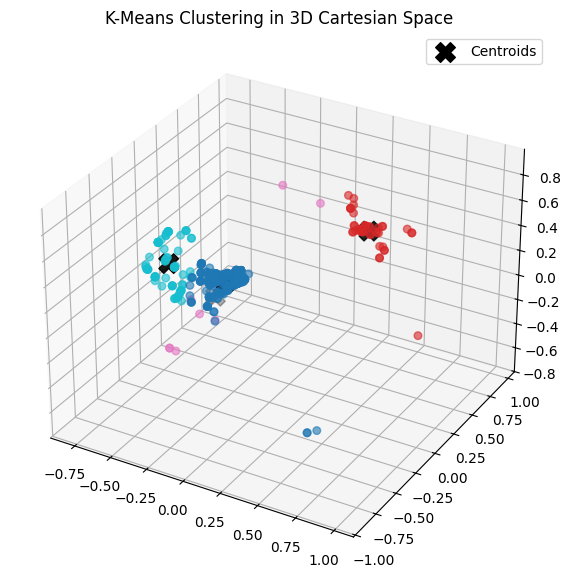

In [170]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2],
    c=labels, cmap='tab10', alpha=0.6, s=30
)

# Plot cluster centers
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2],
    c='black', marker='X', s=200, label='Centroids'
)

ax.set_title('K-Means Clustering in 3D Cartesian Space')
ax.legend()

filename = 'K-Means Clustering in 3D Cartesian Space.png'
save_path = os.path.join(folder, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


In [171]:
def cartesian_to_latlon(cart_coords):

    """
    Convert 3D Cartesian coordinates to geographic latitude and longitude.
    
    Inputs:
        cart_coords: numpy array of shape (N, 3), each row is (x, y, z)
    Outputs:
        numpy array of shape (N, 2), each row is (latitude, longitude) in degrees
    """
    
    x, y, z = cart_coords.T
    hyp = np.sqrt(x**2 + y**2)
    lat = np.degrees(np.arctan2(z, hyp))
    lon = np.degrees(np.arctan2(y, x))
    return np.column_stack((lat, lon))

# For data points
latlon_points = cartesian_to_latlon(cartesian_coords)
# For cluster centers
latlon_centers = cartesian_to_latlon(centers)


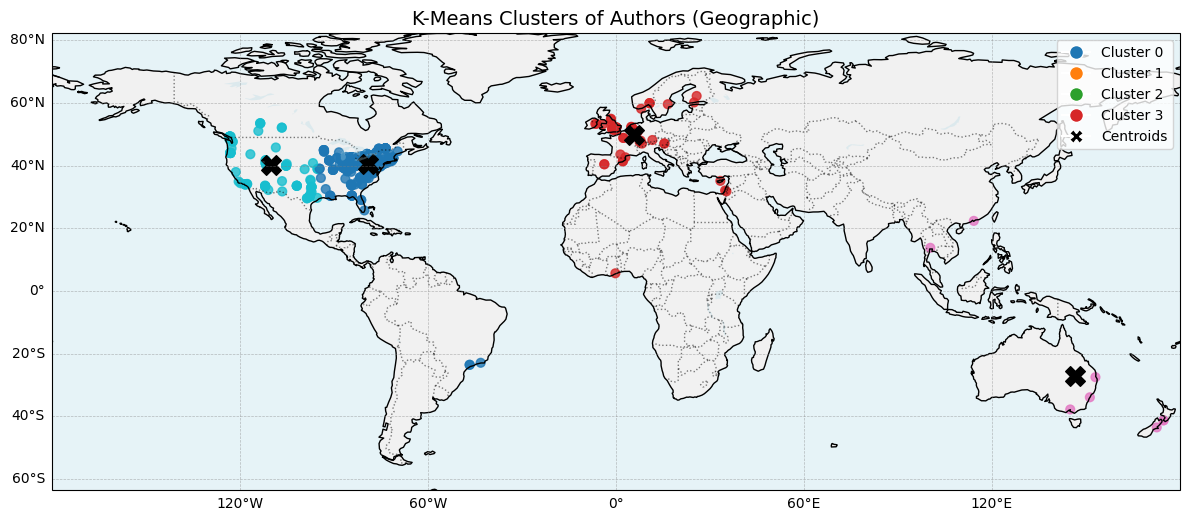

In [172]:
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', alpha=0.3)

scatter = ax.scatter(latlon_points[:, 1], latlon_points[:, 0], 
                    c=labels, cmap='tab10', alpha=0.8, s=40,
                    transform=ccrs.PlateCarree())
                    
# Plot centroids
ax.scatter(latlon_centers[:, 1], latlon_centers[:, 0], 
          c='black', marker='X', s=200, label='Centroids',
          transform=ccrs.PlateCarree())

min_lon, max_lon = np.min(latlon_points[:, 1]) - 20, np.max(latlon_points[:, 1]) + 20
min_lat, max_lat = np.min(latlon_points[:, 0]) - 20, np.max(latlon_points[:, 0]) + 20
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('K-Means Clusters of Authors (Geographic)', fontsize=14)
plt.legend(loc='upper right')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=plt.cm.tab10(i), 
                         markersize=10, label=f'Cluster {i}') 
                  for i in range(len(np.unique(labels)))]
ax.legend(handles=legend_elements + [Line2D([0], [0], marker='X', color='w', 
                                          markerfacecolor='black', 
                                          markersize=10, label='Centroids')],
         loc='upper right')

plt.tight_layout()

filename = 'K-Means Clusters of Authors (Geographic)'
save_path = os.path.join(folder, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


In [173]:
df = pd.DataFrame({
    'x': cartesian_coords[:, 0],
    'y': cartesian_coords[:, 1],
    'z': cartesian_coords[:, 2],
    'cluster': kmeans.labels_,
    'author': df_authors['author']  # Include author names from your DataFrame
})

centers = pd.DataFrame({
    'x': kmeans.cluster_centers_[:, 0],
    'y': kmeans.cluster_centers_[:, 1],
    'z': kmeans.cluster_centers_[:, 2],
    'cluster': ['Center'] * len(kmeans.cluster_centers_),
    'author': ['Cluster Center'] * len(kmeans.cluster_centers_)
})
df = pd.concat([df, centers])

fig = px.scatter_3d(
    df,
    x='x', y='y', z='z',
    color='cluster',
    hover_name='author',
    symbol='cluster',  # Differentiate centers with markers
    title='Author Clusters in 3D Cartesian Space'
)

fig.update_traces(
    marker=dict(size=4),
    selector=dict(mode='markers')
)
fig.show()


In [174]:
# Create a sphere representing Earth
def create_earth_sphere(radius=1):

    """
    Generate 3D coordinates for a sphere (e.g., to represent the Earth).
    
    Inputs:
        radius: radius of the sphere (default 1)
    Outputs:
        x, y, z: 2D numpy arrays of shape (100, 100) representing the sphere's surface
    """

    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2 * np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    return x, y, z

# find optimal cluster with elbow method

In [175]:
error = kmeans.inertia_

wcss = []
k_range = range(1, 11)  # Test 1-10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cartesian_coords)
    wcss.append(kmeans.inertia_)

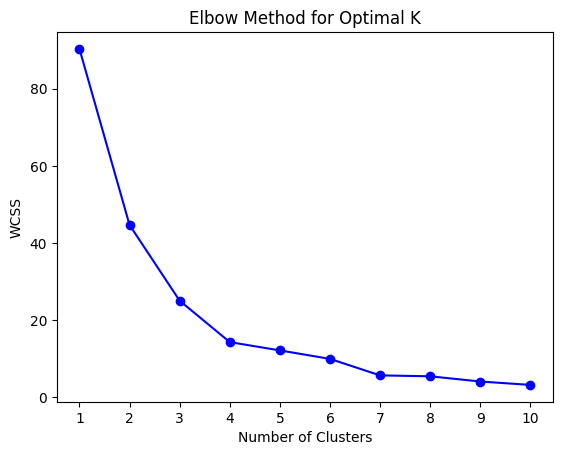

In [176]:
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.show()